# Calcul electron temperature using Coulomb peaks

In [2]:
import sys, os, tempfile
import numpy as np
%matplotlib inline
%gui qt
import matplotlib.pyplot as plt
import qcodes

from qcodes.data.data_set import DataSet
import qtt
from qtt.measurements.scans import scanjob_t

from qtt.dataset_processing import slice_dataset

In [3]:
from qcodes.plots.qcmatplotlib import MatPlot

def plot_dataset(dataset: DataSet) -> None:
    """ Plot a dataset to matplotlib figure window

    Args:
        dataset: DataSet to be plotted
        scanjob: scanjob of the measurement
        save: Select if you want to save the plots

    """
    
    parameter_names = [name for name in dataset.arrays.keys() if not dataset.arrays[name].is_setpoint]
    #default_array = dataset.default_parameter_array()
    
    last_key = list(dataset.arrays.keys())[-1]
    default_array = dataset.arrays[last_key]
    
    # 2D plots
    if len(default_array.shape) >= 2:
        for idx, parameter_name in enumerate(parameter_names):
                plot_handle = MatPlot(dataset.arrays[parameter_name], num=idx)
                plot_handle.rescale_axis()


    # 1D plots        
    else:
        for idx, parameter_name in enumerate(parameter_names):
            plot_handle = MatPlot(dataset.arrays[parameter_name], num=idx)
            plot_handle.rescale_axis()

## Data 

In [4]:
# set data directory
path_save = r'K:\Yona\Measurements'
datadir = os.path.join(path_save, '20210224_10721_S22_TopRight_device')
DataSet.default_io = qcodes.data.io.DiskIO(datadir)

In [5]:
#open window with all the plots
logviewer = qtt.gui.dataviewer.DataViewer(data_directory=datadir, verbose=1)

findfilesR: K:\Yona\Measurements\20210224_10721_S22_TopRight_device: 0.0%
findfilesR: K:\Yona\Measurements\20210224_10721_S22_TopRight_device: 96.2%
DataViewer: found 368 files


Fetch the active dataset from the viewer

In [6]:
# use the plot select in the window for data
dataset = logviewer.dataset
print( dataset )

DataSet:
   location = 'K:\\Yona\\Measurements\\20210224_10721_S22_TopRight_device\\2021-03-02\\13-06-20_qtt_Coulomb_Oscillation'
   <Type>   | <array_id>      | <array.name> | <array.shape>
   Setpoint | PM              | None         | (110,)
   Measured | dmm_curr_sensor | None         | (110,)


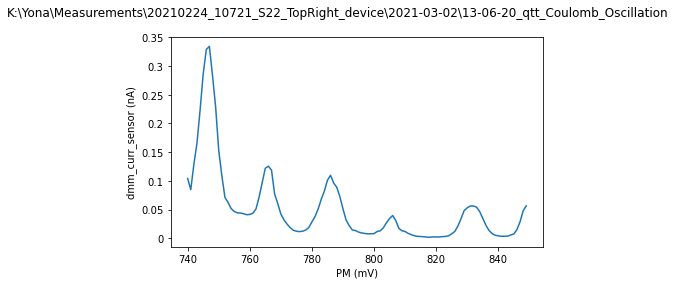

In [7]:
plot_dataset(dataset)

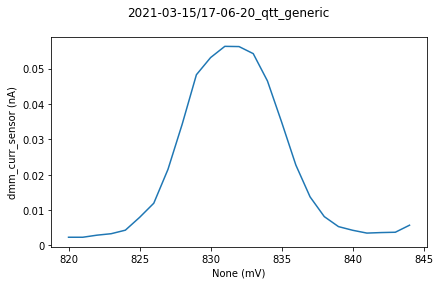

In [8]:
#select only a part of the data
slice_data = slice_dataset(dataset, [820, 845], axis=0, copy_metadata=True, output_parameter_name='dmm_curr_sensor')
plot_dataset(slice_data)

## Conversion DataArray-> Data

In [18]:
PM, I = qtt.data.dataset1Ddata(slice_data)
#PM=[x_data[i] for i in range (0,len(x_data))]
#I=[y_data[i] for i in range (0,len(y_data))]

## Conversion current -> conductance 

$G=\frac{I}{V_{QD}}$

### Real tension applied on QD

The voltage that we apply is not the one applied on the QD because there are other resitances.
$V_{QD}=V_{bias}-R_{elec}I$

In [10]:
Vbias=0.5*10**(-3) #V

In [11]:
R_filter=20*10**3 # Ohm
#R_refl=510*10**3 # Ohm
R_card=102*10**3 # Ohm
R_elec=R_filter+R_card # Ohm

In [21]:
V_QD=[Vbias-R_elec*I[i] for i in range (0,len(I))]

In [22]:
V_QD=Vbias-R_elec*np.array(I)

### Conductance 

In [24]:
G=[I[i]/V_QD[i] for i in range (0,len(I))]

In [25]:
G=I/V_QD

## Qtt function for coulomb peaks 

In [26]:
import qtt.algorithms.coulomb
from qtt.algorithms.coulomb import analyseCoulombPeaks
from qtt.data import load_example_dataset

fitCoulombPeaks: peak 0: position 831.00 max 0.00 valid 1
filterPeaks: 1 -> 1 good peaks
peakScores: noise factor 0.46
peakScores: 0: height 0.0 halfwidth 3.4, score 0.00


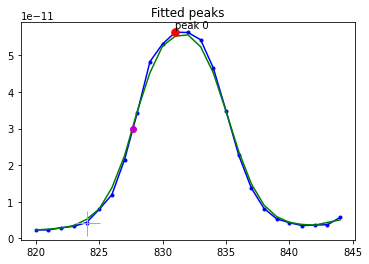

In [27]:
peaks = qtt.algorithms.coulomb.analyseCoulombPeaks(slice_data, fig=10)
_=plt.plot(peaks[0]['xbottom'], peaks[0]['ybottoml'], '+y', markersize=25)

In [9]:
peaks

[{'p': 11,
  'x': 831.0,
  'y': 5.63016354e-11,
  'gaussfit': array([8.31530945e+02, 3.31855607e+00, 4.90607807e-10]),
  'halfvaluelow': 2.9298744989600004e-11,
  'height': 5.40057808208e-11,
  'valid': 1,
  'lowvalue': 2.2958545792000002e-12,
  'type': 'peak',
  'phalf0': 7,
  'phalfl': None,
  'xhalfl': 827.6489368919713,
  'xfoot': 825.1713719994417,
  'yhalfl': 2.979937113e-11,
  'pbottomlow': 0,
  'pbottom': 4,
  'pbottoml': 4,
  'xbottom': 824.0,
  'xbottoml': 824.0,
  'vbottom': 4.29755343e-12,
  'ybottoml': 4.29755343e-12,
  'score': 7.790253337762617e-11,
  'slope': 7.122618686876237e-12,
  'heightscore': 0.9653547511413867,
  'scorerelative': 1.4461091874561913,
  'noisefactor': 0.45674165381781356}]

## Gaussian fit 

In [28]:
from scipy.optimize import curve_fit

In [29]:
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

In [31]:
def gauss_fit(x, y):
    A=0
    B=0
    for i in range (0,len(x)):
        A+=x[i]*y[i]
        B+=y[i]
    mean=A/B
    
    #for i in range (0,len(x)):
    #    A=np.sum(x*y)
    #    B=np.sum(y)
    #mean=A/B
    
    
    C=0
    for j in range (0,len(x)):
        C+=y[j]*(x[j]-mean)**2
    sigma=np.sqrt(C/B)
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

In [32]:
H,A,x0,sigma=gauss_fit(PM,G)

In [33]:
sigma

3.11562427701457

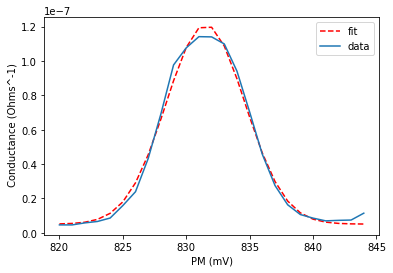

In [36]:
plt.plot(PM,gauss(PM,H,A,x0,sigma),'--r', label='fit')
plt.plot(PM,G,label='data')
plt.xlabel('PM (mV)')
plt.ylabel(' Conductance (Ohms^-1)')
plt.legend()

## Temperature

$T \le \frac{e\alpha_G\Delta V_G^{FWHM}}{4acosh(\sqrt 2)k_B}$ with $\alpha_G \Delta V_G^{FWHM}$ the width of Coulomb peak in units of the dot energy

https://www.ftf.lth.se/fileadmin/ftf/Course_pages/FFF042/cb_lecture07.pdf

In [39]:
e=1.60217662*10**(-19) # C 

In [40]:
k=1.380649*10**(-23) # JK^-1 (VC K^-1)

In [41]:
aV=2.35482*sigma*10**(-3) # V

In [45]:
T_max=e*aV/(4*np.arccosh(np.sqrt(2))*k)
print('Tmax=',T_max,'K')

Tmax= 24.149596534190337 K
